1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup kaggle API key

In [ ]:
# create the .kaggle directory
!mkdir -p ~/.kaggle

# create an empty kaggle.json file
!touch ~/.kaggle/kaggle.json

# change permission so only owner has read and write access
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# edit the kaggle.json file to have username name and api token

import json
kaggle_username = "everylittlething"
kaggle_key = "#########################

with open("/home/studio-lab-user/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download the dataset

In [ ]:
# download the dataset
!kaggle competitions download -c bike-sharing-demand

In [ ]:
# unzip the dataset
!unzip -o bike-sharing-demand.zip

#### import the necessary modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from autogluon.tabular import TabularPredictor


### Create the training and testing dataset

In [3]:
train = pd.read_csv("train.csv", parse_dates = ["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
#verify the dtype of the datetime column
train.info()

In [5]:
test = pd.read_csv("test.csv", parse_dates = ["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
test.info()

In [4]:
# drop the registered and casual columns as they are not included in the test dataset
train.drop(labels =['casual', 'registered'], axis = 'columns', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [18]:
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Training my first AutoGluon Model

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
initial_predictor = TabularPredictor(label = "count", eval_metric="root_mean_squared_error").fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)


### Review and Visulaize Performance of Models

In [ ]:
initial_results = initial_predictor.fit_summary()

In [ ]:
initial_predictor.leaderboard(silent=True).plot(kind = "bar", x="model", y= "score_val")

### Create predictions from test dataset to submit to kaggle

In [ ]:
predictions = initial_predictor.predict(test)
predictions.head()

In [ ]:
#remove any negative values, as they are not allowed. replace negative values with zero
(predictions < 0).sum()

In [ ]:
def replaceNegative(x):
    if x < 0:
        return 0
    return x

In [ ]:
predictions.apply(replaceNegative)
(predictions < 0).sum()

In [ ]:
submission['count'] = predictions
submission.to_csv("submission.csv", index=False)

#### Submit submissions.cvs

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

#### Review initial score

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

In [ ]:
initial_score = 1.73373

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

In [ ]:
train.hist(figsize=(12,12), xrot = 90)

In [6]:
# create hour day and month feature
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [7]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')


In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
test.info()

In [ ]:
test.head()

array([[<AxesSubplot: title={'center': 'datetime'}>,
        <AxesSubplot: title={'center': 'holiday'}>,
        <AxesSubplot: title={'center': 'workingday'}>],
       [<AxesSubplot: title={'center': 'temp'}>,
        <AxesSubplot: title={'center': 'atemp'}>,
        <AxesSubplot: title={'center': 'humidity'}>],
       [<AxesSubplot: title={'center': 'windspeed'}>,
        <AxesSubplot: title={'center': 'count'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'day'}>,
        <AxesSubplot: title={'center': 'hour'}>, <AxesSubplot: >]],
      dtype=object)

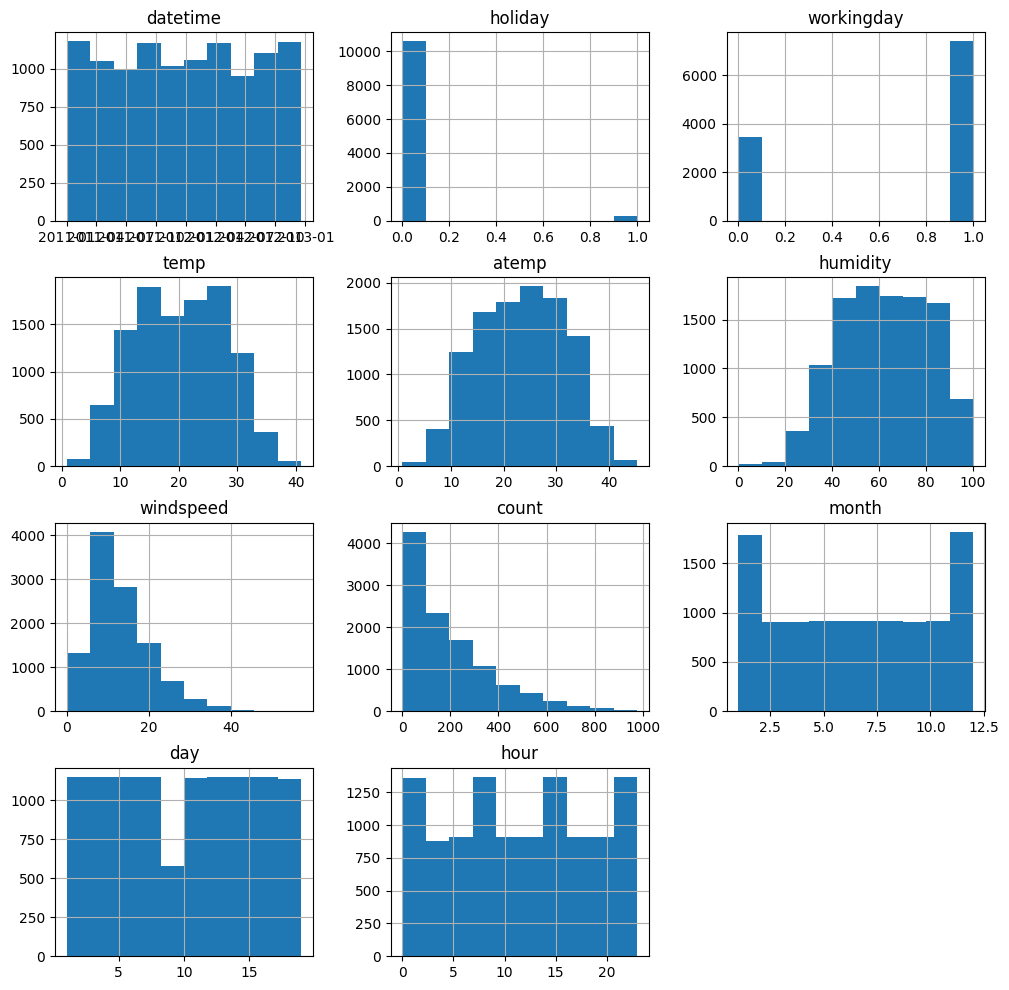

In [143]:
train.hist(figsize=(12,12))

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

In [ ]:
predictor_new_features.fit_summary()

In [ ]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

### Make predictions on the test data using the new predictor

In [ ]:
predictions_new_features = predictor_new_features.predict(test)

In [ ]:
print((predictions_new_features < 0).sum())
# remove any negative values
predictions_new_features = predictions_new_features.apply(replaceNegative)
print((predictions_new_features < 0).sum())

### Sumbit predictions using new features

In [ ]:
submission_new_features = submission

In [ ]:
submission_new_features['count'] = predictions_new_features
submission_new_features.to_csv('submission_new_features.csv', index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "second sunmission-with additional features-with datetime column"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

##### new score with additional features = 0.76168

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

Hyperparameter 1: Turn on autostack

In [ ]:
predictor_hpo_autostack = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True
)

In [ ]:
predictor_hpo_autostack.fit_summary()

In [ ]:
predictor_hpo_autostack.leaderboard(silent=True).plot(kind='bar', x= 'model', y='score_val')

In [ ]:
predictions_autostack = predictor_hpo_autostack.predict(test)

In [ ]:
predictions_autostack = predictions_autostack.apply(replaceNegative)

In [ ]:
submission_hpo_autostack = submission

In [ ]:
submission_hpo_autostack['count'] = predictions_autostack
submission_hpo_autostack.to_csv('submission_hpo_autostack.csv', index=False)

In [ ]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_autostack.csv -m "with features autostack hyperparameter turned on"

Hyperparameter 2: set num_bag_sets to 10

In [ ]:
predictor_hpo_numbagsets = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    num_bag_sets = 10
)

In [ ]:
predictor_hpo_numbagsets.fit_summary()

In [ ]:
predictor_hpo_numbagsets.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
predictions_numbagsets = predictor_hpo_numbagsets.predict(test)

In [ ]:
predictions_numbagsets = predictions_numbagsets.apply(replaceNegative)

In [ ]:
submission_hpo_numbagsets = submission

In [ ]:
submission_hpo_numbagsets['count'] = predictions_numbagsets
submission_hpo_numbagsets.to_csv('submission_hpo_numbagsets.csv', index=False)

In [ ]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_numbagsets.csv -m "with features num_bag_sets hyperparameter set to 10"

In [ ]:
predictor_hpo_both = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True,
    num_bag_sets = 10
)

In [ ]:
predictor_hpo_both.fit_summary()

In [ ]:
predictor_hpo_both.leaderboard(silent=True).plot(kind='bar', x = 'model', y= 'score_val')

In [ ]:
predictions_both = predictor_hpo_both.predict(test)

In [ ]:
predictions_both = predictions_both.apply(replaceNegative)

In [ ]:
submission_hpo_both = submission

In [ ]:
submission_hpo_both['count'] = predictions_both
submission_hpo_both.to_csv('submission_hpo_both.csv', index=False)

In [ ]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_both.csv -m "with features autostack turned on and num_bag_sets set to 10"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 15

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
kaggle_scores = pd.DataFrame(
    {
        "Training run": ["Without added features", "With added features", "Autostack on","Num_bag_sets=10", "Autostack, num_bag_sets"],
        "Kaggle score": [1.73373, 0.76168, 0.70008, 0.72921, 0.71271]
    })

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(kaggle_scores["Training run"], kaggle_scores['score'], color='blue')
ax.set_xticklabels(kaggle_scores['Training run'],rotation=90)
ax.set_xlabel('Training run')
ax.set_ylabel('Kaggle score', color='blue')
ax.tick_params('y', colors='blue')

In [ ]:
fig.savefig('model_kaggle_score.png')

In [ ]:
#the. most performant model in all training runs ws the WeightedEnsemble_l3
model_eval_metric = pd.DataFrame(
    {
        "Training run": ["Without added features", "With added features", "Autostack on","Num_bag_sets=10", "Autostack, num_bag_sets"],
        "Evaluation metric score": [-50.999267, -29.272368, -30.241311, -30.121382, -30.118559]
    }
)

In [ ]:
ax2 = ax.twinx()
ax2.plot(model_eval_metric[ "Training run"], model_eval_metric["Evaluation metric score"], color='red')
ax2.set_ylabel("Evaluation metric score", color='red')
ax2.tick_params('y',colors='red')
plt.show()


In [ ]:
#bbox_inches ='tight' ensures all elements of the figure fits within the image
fig.savefig('evalmetric_kaggle_score.png', bbox_inches='tight')

In [ ]:
summary_df = pd.concat([kaggle_scores, model_eval_metric['Evaluation metric score']], axis=1, join='inner')
summary_df

In [ ]:
summary_df.to_csv('summary_table.csv', index=False)

### Perform log transform on count data

<AxesSubplot: >

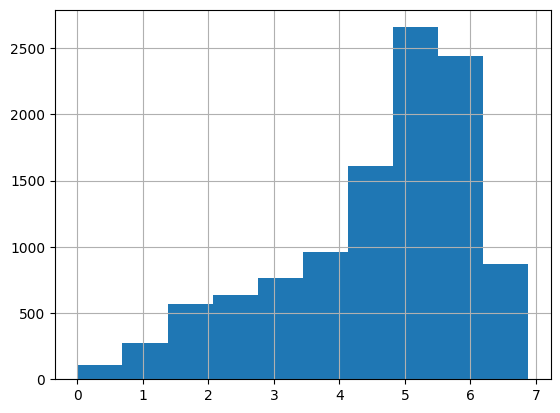

In [9]:
log_count = np.log(train['count'])
log_count.hist()

<AxesSubplot: >

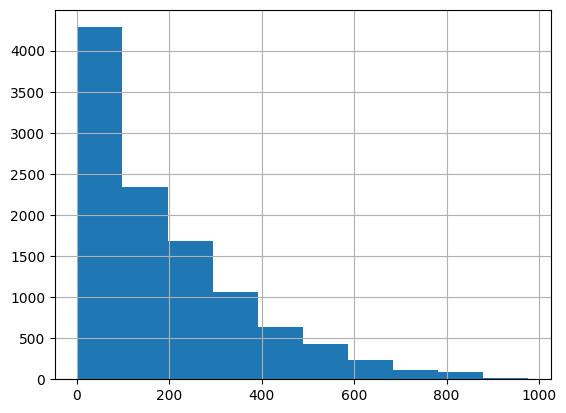

In [10]:
train['count'].hist()

In [11]:
train_ln_transform = train
train_ln_transform['count'] = log_count

#### since we achieved the best score with autostack on, let's try this setting on the ln transform of the count label

In [12]:
predictor_transform_autostack = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train_ln_transform,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230108_215208/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230108_215208/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (6.884486652042782, 0.0, 4.55256, 1.48904)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regressi

In [13]:
predictor_transform_autostack.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.280094      14.600851  516.665521                0.000870           0.546727            3       True         17
1          CatBoost_BAG_L2  -0.282300      12.162794  455.123175                0.170975          90.948841            2       True         14
2          LightGBM_BAG_L2  -0.282778      12.198055  378.989076                0.206236          14.814741            2       True         12
3     ExtraTreesMSE_BAG_L2  -0.285220      12.967439  372.813785                0.975621           8.639451            2       True         15
4      WeightedEnsemble_L2  -0.285299      10.773058  291.564572                0.001509           1.342765            2       True         10
5        LightGBMXT_BAG_L2  -0.286191      12.281024  379.429952                

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -0.67089233467

<AxesSubplot: xlabel='model'>

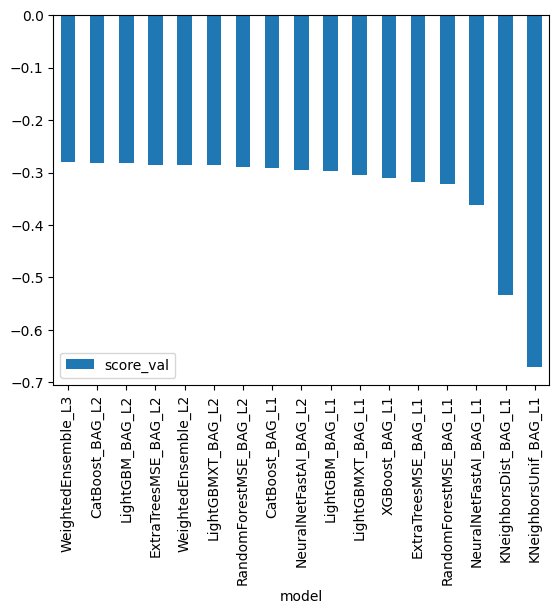

In [14]:
predictor_transform_autostack.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [15]:
test_transform = predictor_transform_autostack.predict(test)

In [16]:
#exponentiate count to undo ln transform
test_transform = np.exp(test_transform)

In [20]:
#make submission file
submission_transform = submission
submission_transform['count'] = test_transform
submission_transform.to_csv('submission_transform.csv',index=False)


In [21]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_transform.csv -m "with features, autostack on, ln transform of count"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 213kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 2

kaggle score after performing ln transform: 0.56869